# Описание соревнований.

## <a href='https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description'>House Prices - Advanced Regression Techniques</a>

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
from scipy import stats
from datetime import datetime 
from sklearn.model_selection import train_test_split, cross_val_score,  KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
matplotlib.rcParams.update({'font.size': 14})
TRAIN_PATH = './house-prices-advanced-regression-techniques/train.csv'
TEST_PATH = './house-prices-advanced-regression-techniques/test.csv'
SUBMIT_PATH = './house-prices-advanced-regression-techniques/sample_submission.csv'
df_train = pd.read_csv(TRAIN_PATH, sep=',')

## 2. Загрузка данных в Data Frame
#### Описание файлов
- train.csv - тренировочные данные
- test.csv - тестовые данные
- sampleSubmission.csv - образец файла для отправки в правильном формате
#### Описание признаков данных
- Id: identification number
- MSSubClass: Identifies the type of dwelling involved in the sale.	
- MSZoning: Identifies the general zoning classification of the sale.
- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- Street: Type of road access to property
- Alley: Type of alley access to property
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- LandSlope: Slope of property
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to various conditions
- Condition2: Proximity to various conditions (if more than one is present)
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Rates the overall material and finish of the house
- OverallCond: Rates the overall condition of the house
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- ExterQual: Evaluates the quality of the material on the exterior 
- ExterCond: Evaluates the present condition of the material on the exterior
- Foundation: Type of foundation
- BsmtQual: Evaluates the height of the basement
- BsmtCond: Evaluates the general condition of the basement
- BsmtExposure: Refers to walkout or garden level walls
- BsmtFinType1: Rating of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Rating of basement finished area (if multiple types)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system
- 1stFlrSF: First Floor square feet
 - 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
- Kitchen: Kitchens above grade
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Functional: Home functionality (Assume typical unless deductions are warranted)
- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition
- PavedDrive: Paved driveway
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- PoolQC: Pool quality
- Fence: Fence quality
- MiscFeature: Miscellaneous feature not covered in other categories
- MiscVal: $Value of miscellaneous feature
- MoSold: Month Sold (MM)
- YrSold: Year Sold (YYYY)
- SaleType: Type of sale
- SaleCondition: Condition of sale

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 6)) + "\n" +
            "Train MAE:\t" + str(round(mae(train_true_values, train_pred_values), 6)) + "\n" +
            "Train MSE:\t" + str(round(mse(train_true_values, train_pred_values), 6)))

    print("\n" +
            "Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 6)) + "\n" +
            "Test MAE:\t" + str(round(mae(test_true_values, test_pred_values), 6)) + "\n" +
            "Test MSE:\t" + str(round(mse(test_true_values, test_pred_values), 6)))
    
    plt.figure(figsize=(15,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()
    
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                        c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                        alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                    components_with_labels_df['component_2'], 
                    components_with_labels_df['component_3'], 
                    c=components_with_labels_df.iloc[:, -1], 
                    cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                    components_with_labels_df['component_2'], 
                    components_with_labels_df['component_3'], 
                    alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique_labels, labels_counts)

    plt.xlabel('Clusters')
    plt.xticks(unique_labels)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

## Исследование целевой переменной
### Построим график распределения целевой переменной "Price" - стоимости квартир

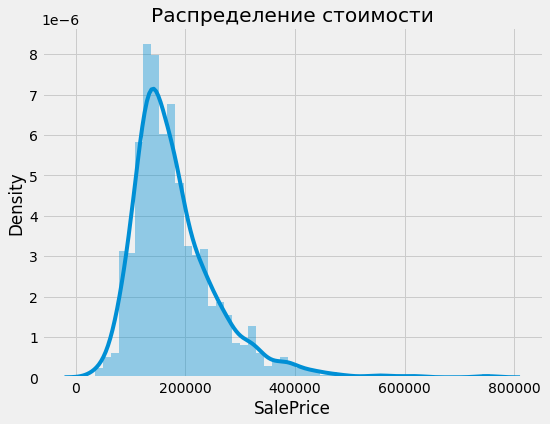

In [3]:
plt.figure(figsize = (8, 6))
sns.distplot(df_train['SalePrice'])
plt.title('Распределение стоимости')
plt.show()

### *Вывод: плотность распределения целевой переменной - нормальная. Большинство квартир встречаются в среднем ценовом диапазоне, по мере увеличения стоимости жилья распределение падает.*

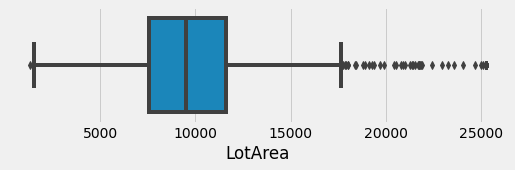


Количество пропущенных элементов 0
Количество уникальных элементов 1044
median - 9478.500
mean - 9884.285
mode - 25250.000
квантиль 5% - 3311.700
квантиль 98% - 25222.100
1300      1
1477      1
1491      1
1526      1
1533      2
         ..
24090     1
24682     1
25000     1
25095     1
25250    30
Name: LotArea, Length: 1044, dtype: int64


In [12]:
df = df_train.copy()
index = 'LotArea'
index_Neighborhood = 'Neighborhood'
q_LotArea = 25250 # 98%

medians = df.median()
# Вычислите среднее значение 'LotFrontage' в каждом районе Neighborhood
np.round_(df.groupby([index_Neighborhood])[index].agg('mean'), decimals = 0).to_dict()
mean_LotArea_Neighborhood = np.round_(df.groupby([index_Neighborhood])[index].agg('mean'), decimals = 0).to_dict()

# Заполним средними значениями по районам, если отсутствует то заполним средним по диапазону.  
df.loc[df[index].isna(), index] = df[index_Neighborhood].map(mean_LotArea_Neighborhood)
df[index].fillna(medians[index], inplace=True)       
# Ограничим сверху квантилем 
df[index].clip(upper=q_LotArea, axis=0, inplace=True)

plt.figure(figsize=(8, 2))
sns.boxplot(df[index], whis=1.5)
plt.xlabel(index)
plt.show()
print(f'\nКоличество пропущенных элементов {df[index].isnull().sum()}')
quantile = df.loc[df[index].notnull(), index]
print(f'Количество уникальных элементов {quantile.value_counts().size}')
print(f'median - {np.quantile(quantile, q=0.5):.3f}\nmean - {np.mean(quantile):.3f}\nmode - {stats.mode(quantile)[0][0]:.3f}')
print(f'квантиль 5% - {np.quantile(quantile, q=0.05):.3f}\nквантиль 98% - {np.quantile(quantile, q=0.98):.3f}')
print(df[index].value_counts().sort_index(ascending=True))

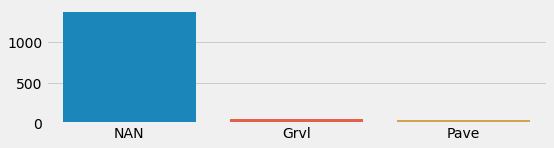


Количество пропущенных элементов 0
NAN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

Количество уникальных элементов 3


In [21]:
df = df_train.copy()
index = 'Alley'
df[index].fillna('NAN', inplace=True) 
df = pd.get_dummies(df, columns=[index], prefix=index)

counts = df[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()
print(f'\nКоличество пропущенных элементов {df[index].isnull().sum()}')
print(df[index].value_counts())
print(f'\nКоличество уникальных элементов {df[index].value_counts().size}')

## Обработка данных и создание новых фич

In [22]:
df = df_train.copy()
index_2 = 'YearRemodAdd'
index_1 = 'YearBuilt'
# обработаем ситуацию когда этаж больше этажности
(df[index_1] > df[index_2]).value_counts()
#df.loc[(df['Floor'] > df['HouseFloor']), 'HouseFloor'] = df.loc[(df['Floor'] > df['HouseFloor']),'Floor']

False    1460
dtype: int64

In [13]:
class DataPreprocessing():
    def __init__(self):
        self.MSZoning_list = {'FV':'MSZoning_FV', 'C (all)':'MSZoning_C (all)', 'RH':'MSZoning_RH', 'RL':'MSZoning_RL', 'RM':'MSZoning_RM'}
        self.medians = None
        self.mean_LotFrontage_Neighborhood = None
        self.mean_LotArea_Neighborhood = None

    def fit(self, df):
        df = df.copy()
        # Вычислите среднее значение
        self.medians = df.median()

        index_Neighborhood = 'Neighborhood'
        # Вычислите среднее значение 'LotFrontage' в каждом районе Neighborhood
        self.mean_LotFrontage_Neighborhood = np.round_(df.groupby([index_Neighborhood])[index].agg('mean'), decimals = 0).to_dict()
        # Вычислите среднее значение 'LotArea' в каждом районе Neighborhood
        self.mean_LotArea_Neighborhood = np.round_(df.groupby([index_Neighborhood])[index].agg('mean'), decimals = 0).to_dict()
        
    def transform(self, df):
        df = df.copy()

        # Переведём 'MSSubClass' признак из категориального в бинарный
        index = 'MSSubClass'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)

        # Переведём 'MSZoning' признак из категориального в бинарный
        index = 'MSZoning'
        df[list(self.MSZoning_list.values())] = 0
        for i in df[index].value_counts().index:
            if i in list(self.MSZoning_list.keys()):
                df.loc[df[index] == i, self.MSZoning_list[i]] = 1
            else:
                df.loc[df[index] == i, 'MSZoning_C (all)'] = 1
        df.drop([index], axis=1, inplace=True)

        index_Neighborhood = 'Neighborhood'
        # Признак 'LotFrontage' заполним средними значениями по районам 'Neighborhood', если отсутствует то заполним средним по диапазону.  
        index = 'LotFrontage'
        q = 120 # 98%
        df.loc[df[index].isna(), index] = df[index_Neighborhood].map(self.mean_LotFrontage_Neighborhood)
        df[index].fillna(medians[index], inplace=True)       
        # Ограничим сверху квантилем 98%
        df[index].clip(upper=q, axis=0, inplace=True)

        # Признак 'LotArea' заполним средними значениями по районам 'Neighborhood', если отсутствует то заполним средним по диапазону.  
        index = 'LotArea'
        q = 25250 # 98%
        df.loc[df[index].isna(), index] = df[index_Neighborhood].map(mean_LotArea_Neighborhood)
        df[index].fillna(medians[index], inplace=True)       
        # Ограничим сверху квантилем 
        df[index].clip(upper=q, axis=0, inplace=True)

        #удаление 'Street' 
        index = 'Street'
        df.drop([index], axis=1, inplace=True)

        # Переведём 'Alley' признак из категориального в бинарный
        index = 'Alley'
        df[index].fillna('NAN', inplace=True) 
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)

        # Переведём 'LotShape' признак из категориального в бинарный
        index = 'LotShape'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)

        # Переведём 'LandContour' признак из категориального в бинарный
        index = 'LandContour'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)

        #удаление 'Utilities'
        index = 'Utilities'
        df.drop([index], axis=1, inplace=True)

        # Переведём 'LotConfig' признак из категориального в бинарный
        index = 'LotConfig'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)

        # Переведём 'LandSlope' признак из категориального в бинарный
        index = 'LandSlope'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)

        # Переведём 'Condition1' признак из категориального в бинарный
        index = 'Condition1'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)
        
        #удаление 'Condition2'
        index = 'Condition2'
        df.drop([index], axis=1, inplace=True)
        
        # Переведём 'BldgType' признак из категориального в бинарный
        index = 'BldgType'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)
        
        # Переведём 'HouseStyle' признак из категориального в бинарный
        index = 'HouseStyle'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)

        # Переведём 'RoofStyle' признак из категориального в бинарный
        index = 'RoofStyle'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)






        
        # Переведём 'LandSlope' признак из категориального в бинарный
        index = 'Neighborhood'
        df = pd.get_dummies(df, columns=[index], prefix=index)
        df.drop([index], axis=1, inplace=True)

        return df